<a href="https://colab.research.google.com/github/sravyagadam/ML_REGRESSION_CAPSTONE/blob/main/RetailSalesPrediction_ML_sravya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
store_data = pd.read_csv('/content/drive/MyDrive/RetailSalesPrediction_Sravya/Rossmann Stores Data.csv')
stores = pd.read_csv('/content/drive/MyDrive/RetailSalesPrediction_Sravya/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#store_data.dropna(inplace=True)
#stores.dropna(inplace=True)
store_data.fillna(0)
store_data.fillna(0)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
store_data = store_data[store_data.Open != 0]

In [6]:
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
store_data['Date']= pd.to_datetime(store_data['Date'])

In [9]:
store_data['Year'] = pd.DatetimeIndex(store_data['Date']).year
store_data['Month'] = pd.DatetimeIndex(store_data['Date']).month

In [10]:
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7


In [63]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
CompetitionOpen              246
promoYearWeek                246
dtype: int64

In [11]:
## Wherever Promo2 ie continuing and consecutive promotion is zero, implies store didn't participate,
# hence Promo2SinceWeek and Promo2SinceYear should be zero, also there won't be PromoInterval
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceWeek'].isna()),['Promo2SinceWeek']]=0
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceYear'].isna()),['Promo2SinceYear','PromoInterval']]=0

In [12]:
stores.loc[stores['CompetitionDistance'].isna()]=stores['CompetitionDistance'].max()#CompetitionDistance

In [94]:
stores.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [114]:
store_data['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [14]:
stores[stores['Promo2SinceYear']!=0]['Promo2SinceYear'].min()

2009.0

In [13]:
### Code Ref https://www.kaggle.com/shivam017arora/rossmann-sales-prediction-top-1-solution
## Modified accordingly

competition_open = []
for index, value in stores[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
    try:
        year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
        date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
        competition_open.append(date)
    except:
        competition_open.append('1813-01-01') # Added a dummy date, 200 yrs less than min sales date
stores['CompetitionOpen'] = pd.Series(competition_open)
stores['CompetitionOpen'] = stores['CompetitionOpen'].dt.strftime('%Y-%m-%d')
stores['CompetitionOpen']= pd.to_datetime(stores['CompetitionOpen'])





promo = []
for index, value in stores[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
    try:
        year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
        date = pd.to_datetime("{}{}0".format(year, week), format='%Y%W%w')
        promo.append(date)
    except:
        promo.append('1909-01-01')   ## dummy date
stores['promoYearWeek'] = pd.to_datetime(pd.Series(promo))
stores['promoYearWeek'] = stores['promoYearWeek'].dt.strftime('%Y%m%d')
stores['promoYearWeek']= pd.to_datetime(stores['promoYearWeek'])


In [15]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1115 non-null   int64         
 1   StoreType                  1115 non-null   object        
 2   Assortment                 1115 non-null   object        
 3   CompetitionDistance        1115 non-null   float64       
 4   CompetitionOpenSinceMonth  764 non-null    float64       
 5   CompetitionOpenSinceYear   764 non-null    float64       
 6   Promo2                     1115 non-null   int64         
 7   Promo2SinceWeek            1115 non-null   float64       
 8   Promo2SinceYear            1115 non-null   float64       
 9   PromoInterval              1115 non-null   object        
 10  CompetitionOpen            1115 non-null   datetime64[ns]
 11  promoYearWeek              1115 non-null   datetime64[ns]
dtypes: dat

In [16]:
store_data_merged=pd.merge(store_data,stores,on='Store')

In [17]:
store_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842206 entries, 0 to 842205
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      842206 non-null  int64         
 1   DayOfWeek                  842206 non-null  int64         
 2   Date                       842206 non-null  datetime64[ns]
 3   Sales                      842206 non-null  int64         
 4   Customers                  842206 non-null  int64         
 5   Open                       842206 non-null  int64         
 6   Promo                      842206 non-null  int64         
 7   StateHoliday               842206 non-null  object        
 8   SchoolHoliday              842206 non-null  int64         
 9   Year                       842206 non-null  int64         
 10  Month                      842206 non-null  int64         
 11  StoreType                  842206 non-null  object  

In [18]:
store_data_merged['day_diff_comp']=(store_data_merged['Date']-store_data_merged['CompetitionOpen']).dt.days
store_data_merged['day_diff_promo']=(store_data_merged['Date']-store_data_merged['promoYearWeek']).dt.days
store_data_merged.loc[store_data_merged['day_diff_comp']>=73000,'day_diff_comp']=0
store_data_merged.loc[store_data_merged['day_diff_promo']>=36500,'day_diff_promo']=0

In [19]:
store_data_merged.drop(columns=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceWeek','Promo2SinceYear','PromoInterval','CompetitionOpen','promoYearWeek'],inplace=True)

In [20]:
store_data_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,c,a,1270.0,0,2524,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,7,c,a,1270.0,0,2523,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,7,c,a,1270.0,0,2522,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,7,c,a,1270.0,0,2521,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,7,c,a,1270.0,0,2520,0


In [21]:
store_data_merged['CompetitionDistance']=store_data_merged['CompetitionDistance'].astype(int)

In [22]:
store_data_merged = store_data_merged.reset_index()

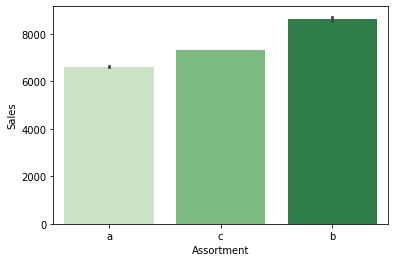

In [23]:
Assortment_Sales = sns.barplot(x='Assortment', y='Sales', data= store_data_merged, palette='Greens')
Assortment_Sales

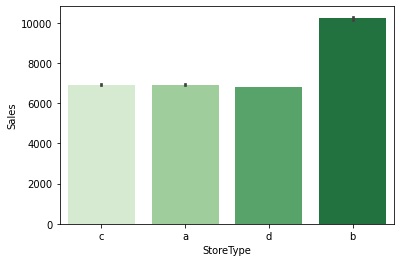

In [24]:
StoreType_sales = sns.barplot(x='StoreType', y='Sales', data= store_data_merged, palette='Greens')
StoreType_sales

In [25]:
store_data_merged['Assortment']=store_data_merged['Assortment'].apply(lambda x: 1 if x=='a' else (2 if x=='b' else 3))

In [26]:
store_data_final=pd.get_dummies(store_data_merged,drop_first=True)

In [142]:
store_data_final.isna().sum()


Store                       0
DayOfWeek                   0
Date                        0
Sales                       0
Customers                   0
Open                        0
Promo                       0
SchoolHoliday               0
Year                        0
Month                       0
Assortment                  0
CompetitionDistance         0
Promo2                      0
day_diff_comp          179845
day_diff_promo         179845
StateHoliday_0              0
StateHoliday_a              0
StateHoliday_b              0
StateHoliday_c              0
StoreType_c                 0
StoreType_d                 0
dtype: int64

In [27]:
store_data_final.drop(columns=['Date'],inplace=True) ## Dropping Date column as month and year have been extracted

In [28]:
store_data_final = store_data_final.reset_index()

In [30]:
def clean_dataset(store_data_final):
    assert isinstance(store_data_final, pd.DataFrame), "df needs to be a pd.DataFrame"
    store_data_final.dropna(inplace=True)
    indices_to_keep = ~store_data_final.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [29]:
store_data_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [31]:
store_data_final.head()

,level_0,index,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d
0,0,0,1,5,5263,555,1,1,1,2015,7,1,1270,0,2524,0,1,0,0,0,0,1,0
1,1,1,1,4,5020,546,1,1,1,2015,7,1,1270,0,2523,0,1,0,0,0,0,1,0
2,2,2,1,3,4782,523,1,1,1,2015,7,1,1270,0,2522,0,1,0,0,0,0,1,0
3,3,3,1,2,5011,560,1,1,1,2015,7,1,1270,0,2521,0,1,0,0,0,0,1,0
4,4,4,1,1,6102,612,1,1,1,2015,7,1,1270,0,2520,0,1,0,0,0,0,1,0


In [101]:
store_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842206 entries, 0 to 842205
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   level_0              842206 non-null  int64
 1   index                842206 non-null  int64
 2   Store                842206 non-null  int64
 3   DayOfWeek            842206 non-null  int64
 4   Sales                842206 non-null  int64
 5   Customers            842206 non-null  int64
 6   Open                 842206 non-null  int64
 7   Promo                842206 non-null  int64
 8   SchoolHoliday        842206 non-null  int64
 9   Year                 842206 non-null  int64
 10  Month                842206 non-null  int64
 11  Assortment           842206 non-null  int64
 12  CompetitionDistance  842206 non-null  int64
 13  Promo2               842206 non-null  int64
 14  day_diff_comp        842206 non-null  int64
 15  day_diff_promo       842206 non-null  int64
 16  St

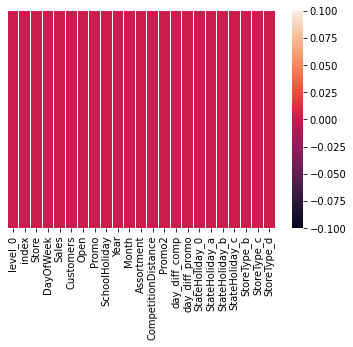

In [59]:
sns.heatmap(store_data_final.isnull(),yticklabels=False)
#From the heatmap, it is clear that there are no null values.

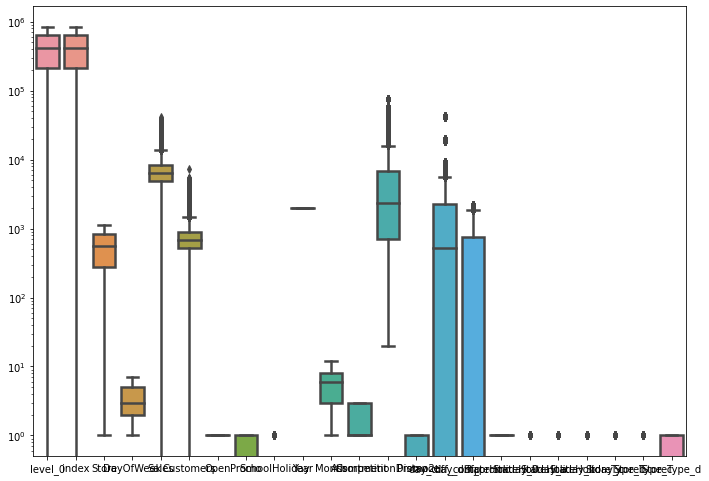

In [60]:
# To check outliers 
#import matplotlib.pyplot as plt


a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=store_data_final,linewidth=2.5,ax=ax)
g.set_yscale("log")

In [103]:
#this correlation uses pearson method
store_data_final.corr().style.background_gradient(cmap='viridis')

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,level_0,index,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d
level_0,1.000000,1.000000,0.996765,0.000323,0.008475,0.035153,nan,-0.000003,0.000545,-0.000582,0.001537,0.002671,-0.026941,0.004776,0.003200,-0.018210,-0.002178,0.002716,0.000279,0.000400,-0.001426,0.059714,-0.052575
index,1.000000,1.000000,0.996765,0.000323,0.008475,0.035153,nan,-0.000003,0.000545,-0.000582,0.001537,0.002671,-0.026941,0.004776,0.003200,-0.018210,-0.002178,0.002716,0.000279,0.000400,-0.001426,0.059714,-0.052575
Store,0.996765,0.996765,1.000000,0.000342,0.008903,0.035094,nan,0.000003,0.000564,0.000341,0.001549,0.005509,-0.027049,0.006430,0.002001,-0.015774,-0.002155,0.002807,0.000317,0.000429,-0.001045,0.060943,-0.050658
DayOfWeek,0.000323,0.000323,0.000342,1.000000,-0.178561,-0.097067,nan,-0.289274,-0.139322,0.002101,-0.019726,0.001204,0.005535,-0.003264,-0.001967,-0.004797,0.010223,0.000828,-0.008687,0.002705,0.038075,-0.003191,-0.004081
Sales,0.008475,0.008475,0.008903,-0.178561,1.000000,0.823311,nan,0.368126,0.038535,0.036201,0.073393,0.109732,-0.036396,-0.127628,-0.004366,-0.057057,0.030142,0.014076,0.012379,0.008235,0.144619,-0.003401,-0.028515
Customers,0.035153,0.035153,0.035094,-0.097067,0.823311,1.000000,nan,0.182724,0.024810,-0.000819,0.053708,0.007561,-0.148506,-0.202503,-0.005188,-0.145279,0.007113,0.036935,0.030196,0.018437,0.430228,0.051182,-0.259507
Open,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Promo,-0.000003,-0.000003,0.000003,-0.289274,0.368126,0.182724,nan,1.000000,0.029012,0.023991,-0.006400,-0.000336,-0.002393,-0.000300,0.002284,0.005178,0.004073,0.006221,-0.002680,-0.008244,-0.017851,0.002176,0.001003
SchoolHoliday,0.000545,0.000545,0.000564,-0.139322,0.038535,0.024810,nan,0.029012,1.000000,-0.038651,0.118533,-0.002731,-0.004280,-0.008238,-0.000125,-0.003078,-0.067884,-0.003125,0.025408,0.018740,-0.003011,0.002751,-0.003301
Year,-0.000582,-0.000582,0.000341,0.002101,0.036201,-0.000819,nan,0.023991,-0.038651,1.000000,-0.268783,0.001986,0.000626,-0.005669,0.086540,0.216679,-0.084559,0.002568,0.003070,-0.004005,0.003191,0.001208,-0.002333


#Selecting the columns for Training
'Store', 'DayOfWeek',  'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2',
       'Promo2SinceYear', 'PromoInterval',
       'Promo2Open', 'IsPromo2Month'



In [33]:
dependent_variable = 'Sales'

In [34]:
independent_variables = ['Customers', 'DayOfWeek', 'Open',
       'Promo', 'SchoolHoliday', 'Year',
       'Month', 'Assortment', 'CompetitionDistance','Promo2',
       'day_diff_comp','day_diff_promo','StateHoliday_0','StateHoliday_a','StateHoliday_b',
       'StateHoliday_c','StoreType_b','StoreType_c','StoreType_d']

##Adding dependent variables and independent variables 

In [35]:
X = store_data_final[independent_variables]
y = store_data_final[dependent_variable]

##Splitting the data into test and train data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=324)

In [37]:
Train_y = np.nan_to_num(y_train)
Train_X = np.nan_to_num(X_train)

##Calculating entropy and Visualizing Decision tree

In [114]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import metrics
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.metrics import accuracy_score as acc
from datetime import datetime

In [66]:
reg= ExtraTreesRegressor()

In [67]:
reg.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [68]:
reg.feature_importances_

array([6.48223398e-01, 2.39945968e-02, 0.00000000e+00, 1.21560161e-01,
       3.13859872e-03, 6.04720707e-03, 1.10716568e-02, 1.76921130e-02,
       5.92289275e-02, 8.65826703e-03, 2.63380875e-02, 1.22694470e-02,
       1.51665598e-03, 2.05115967e-04, 7.19534642e-05, 5.52347684e-05,
       2.12920506e-02, 5.01639083e-03, 3.36201374e-02])

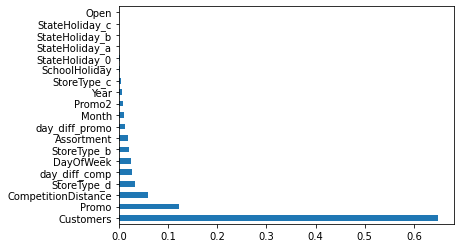

In [71]:
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

#Decision tree modelling using hyper tuning

In [ ]:
accuracy_score(y_test, y_predicted) * 100

In [ ]:
graph = Source(tree.export_graphviz(humidity_classifier, out_file=None
   , feature_names=X_train.columns, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [74]:
reg_decision_model=DecisionTreeRegressor()

In [75]:
reg_decision_model.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [76]:
reg_decision_model.score(X_train,y_train)

0.9999967339743805

In [77]:
reg_decision_model.score(X_test,y_test)

0.9412603787390137

# As the score is not satisfactory , it is time for hypertuning 

In [78]:
prediction=reg_decision_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


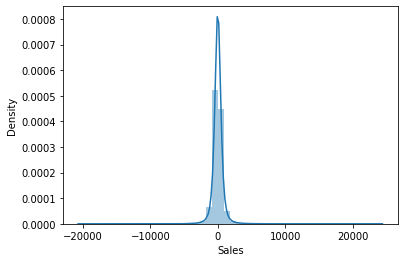

In [79]:
# checking difference between labled y and predicted y
sns.distplot(y_test-prediction)

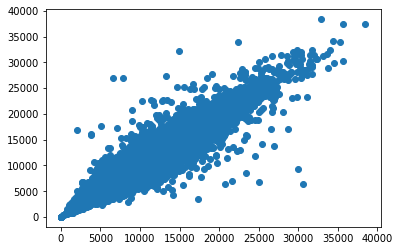

In [80]:
#checking predicted y and labeled y using a scatter plot.

plt.scatter(y_test,prediction)

In [110]:
# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "criterion": ['gini', 'entropy'],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [111]:
tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [112]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)

In [ ]:
start_time=timer(None)
tuning_model.fit(X,y)
timer(start_time)

Fitting 3 folds for each of 100800 candidates, totalling 302400 fits
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=50, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=60, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=6, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=7, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=8, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=9, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=70, min_samples_leaf=10, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.1s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=1, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=2, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=4, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.4, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.5, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.6, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.7, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.8, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=5, min_weight_fraction_leaf=0.9, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.1, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.2, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'gini'

  FitFailedWarning)


[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=best, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 
[CV]  criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random, score=nan, total=   0.2s
[CV] criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random 


In [ ]:
## getting the best params from the above step for fine tuning 
tuning_model.best_params_

In [87]:
# best model score
tuning_model.best_score_

AttributeError: ignored

#Training Decision Tree With Best Hyperparameters as given by the step

In [88]:
tuned_hyper_model= DecisionTreeRegressor(max_depth=5,max_features='auto',max_leaf_nodes=50,min_samples_leaf=2,min_weight_fraction_leaf=0.1,splitter='random')

In [89]:
# fitting model


tuned_hyper_model.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=50,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.1, presort='deprecated',
                      random_state=None, splitter='random')

In [90]:
# prediction 

tuned_pred=tuned_hyper_model.predict(X_test)

In [92]:
print('MAE:', metrics.mean_absolute_error(y_test,tuned_pred))
print('MSE:', metrics.mean_squared_error(y_test, tuned_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, tuned_pred)))

MAE: 2046.014684801246
MSE: 8039413.132710958
RMSE: 2835.385887795691


In [93]:
# without hyperparameter tuning 
print('MAE:', metrics.mean_absolute_error(y_test,prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 483.424448771684
MSE: 565578.5403802034
RMSE: 752.0495597899139
